# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### 1.  Изучаем данные

#### 1.1 Изучим таблицу с информацей о звонках

In [91]:
import pandas as pd
data_calls=pd.read_csv('/datasets/calls.csv')
data_calls.head()
data_calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице 4 столбца, отстутствуют пропущенные значения. При этом подозрительны звонки с продолжительностью 0.0 минут и секунд, хотя известно, что "Мегалайн" округляет вверх значение минут. Столбец 'user_id' это уникальный идентификатор пользователя, его тип нужну привести к object.

#### 1.2 Изучим таблицу с информацией об  интернет-сессиях.

In [92]:
data_internet=pd.read_csv('/datasets/internet.csv')
data_internet.head()
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


В таблице нет пропущенных значений. Нужно поменять тип данных в столбце 'user_id'. На первый взгляд все впорядке.

#### 1.3 Изучим таблицу с информацией о сообщениях.

In [93]:
data_messages=pd.read_csv('/datasets/messages.csv')
print(data_messages.head())
data_messages.info()

       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице нет пропущенных значений. Нужно поменять тип данных в столбце 'user_id'. На первый взгляд все впорядке.

#### 1.4 Изучим таблицу с информацией о тарифах.

In [94]:
data_tariffs=pd.read_csv('/datasets/tariffs.csv')
data_tariffs.head()
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице нет пропущенных значений.  На первый взгляд все впорядке.

#### 1.5 Изучим таблицу с информацией о пользователях.

In [95]:
data_users=pd.read_csv('/datasets/users.csv')
data_users=data_users.rename(columns={'tariff':'tariff_name'})
data_users.head()
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id        500 non-null int64
age            500 non-null int64
churn_date     38 non-null object
city           500 non-null object
first_name     500 non-null object
last_name      500 non-null object
reg_date       500 non-null object
tariff_name    500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице 500 строк, значит у нас есть данные о 500 пользователях. Пропущенные значения только в столбце 'churn_date', что говорит о том, что тариф действовал на момент выгрузки данных. 

### 2. Предобработка данных

#### 2.1 Предобработка таблицы data_calls и data_tariffs

In [96]:
data_calls['duration'].value_counts() # много нулевых значений
# Удаляем нудевые значения 
data_calls=data_calls.query('duration != "0.0"')
data_calls['duration'].value_counts()


4.49     142
5.50     142
6.38     141
6.15     141
4.92     139
        ... 
25.67      1
27.19      1
28.87      1
26.07      1
27.63      1
Name: duration, Length: 2870, dtype: int64

Столбец 'duration' содержит нулевые значения. Возможно это не прошедшие вызовы, или ошибочное округлении значений вниз. в любом случае нельяоднозначно определить причину возникновения пропусков. Было решено убрать нулевые значения, так какони не несут однозначной информации о продолжительности звонков.

In [97]:
# округлим значения в столбце duration таблицы data_calls до целых чисел вверх
import numpy as np
data_calls['duration']=data_calls['duration'].apply(np.ceil)

In [98]:
# округлим значения в столбце mb_used таблицы data_internet до целых чисел вверх
data_internet['mb_used']=data_internet['mb_used'].apply(np.ceil)

В столбцах 'duration' таблицы data_call и 'mb_used' таблицы data_internet все значения были округлены вверх, так как компания Мегалайн всегда округляет вверх значения минут и мегабайтов.

#### 2.2 Замена типа в столбце 'user_id'

In [99]:
data_calls['user_id']=data_calls['user_id'].astype('object')
data_internet['user_id']=data_internet['user_id'].astype('object')
data_messages['user_id']=data_messages['user_id'].astype('object')
data_users['user_id']=data_users['user_id'].astype('object')

Столбец 'user_id' содержит уникальные идентификаторы клиентов, это качетвенная переменная. У неё должен быть тип object.

####  2.3 Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам

In [100]:
#создадим в таблице data_calls столбец с номерами месяцев
import datetime as dt
data_calls['call_date']=pd.to_datetime(data_calls['call_date'], format='%Y-%m-%dT%H:%M:%S')
data_calls['month']=data_calls['call_date'].dt.month

# создадим таблицу с кол-ом сделанных звонков и израсходованных минут
total_talk=data_calls.pivot_table(index=['user_id','month'], values='duration', aggfunc=('count','sum')).reset_index()
# переименуем столбцы count и sum
total_talk = total_talk.rename(columns={'count':'count_talk', 'sum':'sum_time_talk'})

total_talk.head(10)

,user_id,month,count_talk,sum_time_talk
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0
3,1000,8,42,408.0
4,1000,9,46,466.0
5,1000,10,44,350.0
6,1000,11,37,338.0
7,1000,12,38,333.0
8,1001,11,45,430.0
9,1001,12,47,414.0


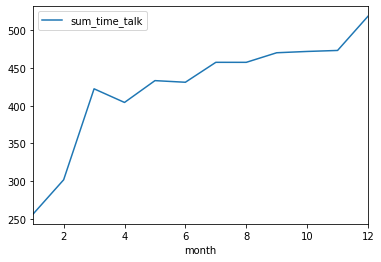

In [101]:
#приведем результаты таблицы total_talk в более наглядный вид
(total_talk
     .pivot_table(index='month', values='sum_time_talk')
     .plot()          
 )

Продолжительность разговоров резко увеличивается с 3-его месяца, затем неуклонно растет.

#### 2.4 Посчитаем количество отправленных сообщений по месяцам

In [102]:
# создадим в таблице data_messages столбец с месяцами
data_messages['message_date']=pd.to_datetime(data_messages['message_date'], format='%Y-%m-%dT%H:%M:%S')
data_messages['month']=data_messages['message_date'].dt.month
#создадим таблицу с количеством сделанных звонков по месяцам
messages_to_month=data_messages.pivot_table(index=['user_id','month'], values ='message_date', aggfunc=('count')).reset_index()
messages_to_month=messages_to_month.rename(columns={'message_date':'message_count'})
messages_to_month.head(10)

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


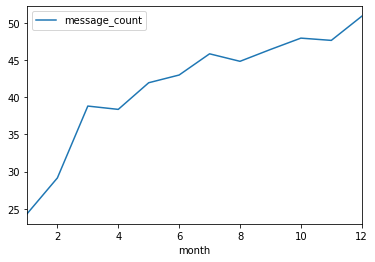

In [103]:
#приведем результаты таблицы messages_to_month в более наглядный вид
(messages_to_month
     .pivot_table(index='month', values='message_count')
     .plot()          
 )

Количество сообщений резко увеличивается с 3-его месяца, затем неуклонно растет.

#### 2.5 Посчитаем объем израсходованного интернет-трафика по месяцам

In [104]:
# создадим в таблице data_internet столбец с месяцами
data_internet['session_date']=pd.to_datetime(data_internet['session_date'], format='%Y-%m-%dT%H:%M:%S')
data_internet['month']=data_internet['session_date'].dt.month
#создадим таблицу с объмом интернет-трафика по месяцам
traffic_to_month=data_internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum').reset_index()
traffic_to_month=traffic_to_month.rename(columns={'mb_used':'mb_used_count'})
traffic_to_month.head(10)



,user_id,month,mb_used_count
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0
5,1000,10,14717.0
6,1000,11,14768.0
7,1000,12,9827.0
8,1001,11,18452.0
9,1001,12,14053.0


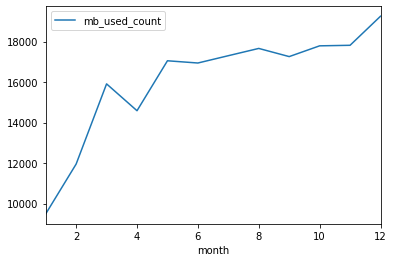

In [105]:
#приведем результаты таблицы traffic_to_month в более наглядный вид
(traffic_to_month
     .pivot_table(index='month', values='mb_used_count')
     .plot()          
 )

 Объём потребления трафика резко увеличивается к 3-ему месяцу. В целом, в течение года объём потребления траффика в месяц увеличиается

#### 2.6 Посчитаем помесячную выручку с каждого пользователя

#### 2.6.1 Создаём сводную таблицу для звонков, сообщений и трафика

In [126]:
# создаём таблицу с тарифами для каждого пользователя
user_tariff = data_users.filter(['user_id', 'tariff_name'],axis=1)
user_tariff=user_tariff.set_index('user_id')
#создаём сводную таблицу
total_talk_mes=total_talk.merge(messages_to_month, on=['user_id','month']).reset_index(drop=True)
total_talk_mes_trf=total_talk_mes.merge(traffic_to_month, on=['user_id','month']).reset_index(drop=True)
total_talk_mes_trf=total_talk_mes_trf.merge(user_tariff, on=['user_id']).reset_index(drop=True)
total_talk_mes_trf=total_talk_mes_trf.merge(data_tariffs, on=['tariff_name']).reset_index(drop=True)
    
total_talk_mes_trf.head(10)


,user_id,month,count_talk,sum_time_talk,message_count,mb_used_count,tariff_name,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,17,159.0,22,2256.0,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,28,172.0,60,23257.0,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,41,340.0,75,14016.0,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,42,408.0,81,14070.0,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,46,466.0,57,14581.0,ultra,1000,30720,3000,1950,150,1,1
5,1000,10,44,350.0,73,14717.0,ultra,1000,30720,3000,1950,150,1,1
6,1000,11,37,338.0,58,14768.0,ultra,1000,30720,3000,1950,150,1,1
7,1000,12,38,333.0,70,9827.0,ultra,1000,30720,3000,1950,150,1,1
8,1003,8,43,380.0,37,8571.0,ultra,1000,30720,3000,1950,150,1,1
9,1003,9,105,961.0,91,12479.0,ultra,1000,30720,3000,1950,150,1,1


#### 2.5.2 Считаем помесячную выручку с каждого пользователя для каждого тарифа

In [107]:
# создаём функцию для подсчёта выручки
def proceed_count(data):
    data['call_revenue']=((data['sum_time_talk']-data['minutes_included'])*data['rub_per_minute'])+data['rub_monthly_fee']
    data['message_revenue']=((data['message_count']-data['messages_included'])*data['rub_per_message'])+data['rub_monthly_fee']
    data['mb_revenue']=(((data['mb_used_count']-data['mg_per_month_included'])/1000)*data['rub_per_gb'])+data['rub_monthly_fee']
    data['total_revenue']=data['call_revenue']+data['message_revenue']+data['mb_revenue']
    
    return data.filter(['user_id','month','tariff_name','total_revenue'])
  
total_table_revenue=total_talk_mes_trf.apply(proceed_count,axis=1)   
total_table_revenue.head()

,user_id,month,tariff_name,total_revenue
0,1000,5,ultra,-2238.60
1,1000,6,ultra,962.55
2,1000,7,ultra,-240.60
3,1000,8,ultra,-158.50
4,1000,9,ultra,-47.85


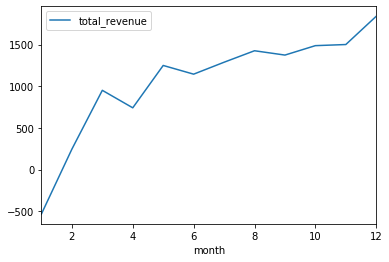

In [108]:
#приведем результаты таблицы total_table_revenue в более наглядный вид
(total_table_revenue
     .pivot_table(index='month', values='total_revenue')
     .plot()          
 )

В первом месяце нет выручки. Средняя задолженность пользователей составляет 500 рублей. При этом опять же к 3-ему месяцу средняя выручка в месяц с каждого пользователя резко возрастает и увеличивается в течение года.

In [127]:
total_table_revenue['month'].value_counts()

12    397
11    376
10    350
9     311
8     284
7     242
6     204
5     170
4     133
3      94
2      64
1      37
Name: month, dtype: int64

Таким образом, резкие скачки значений продолжительности разговора, кол-ва сообщений и объёма данных связаны с тем, что пользователи стали подключаться к этим двум тарифам только в 3-ем месяце.

### 3. Анализ данных

#### 3.1 Среднее количество разговоров, сообщений и трафика для каждого тарифа в месяц

In [109]:
# создаём сводную таблицу и применяем метод mean
import numpy as np
total_talk_mes_trf_stat = total_talk_mes_trf.pivot_table(index=['tariff_name','month'], 
                                                         values=['sum_time_talk','message_count','mb_used_count'],
                                                         ).reset_index()

total_talk_mes_trf_stat

,tariff_name,month,mb_used_count,message_count,sum_time_talk
0,smart,1,8681.100000,19.733333,217.700000
1,smart,2,11954.480000,27.940000,311.740000
2,smart,3,14659.449275,35.550725,393.086957
3,smart,4,13604.136842,35.736842,385.610526
4,smart,5,16174.918033,39.032787,399.606557
5,smart,6,15815.624113,38.510638,399.177305
6,smart,7,15843.695402,38.988506,409.321839
7,smart,8,16868.707921,39.044554,429.460396
8,smart,9,16393.981982,39.252252,429.135135
9,smart,10,16794.762846,39.154150,427.391304


In [110]:
# посчитаем дисперсию
variance_talk = np.var(total_talk_mes_trf_stat['sum_time_talk'], ddof=1)
variance_message = np.var(total_talk_mes_trf_stat['message_count'], ddof=1)
variance_mb_used = np.var(total_talk_mes_trf_stat['mb_used_count'], ddof=1)

In [111]:
#посчитаем стандартное отклонение
standard_deviation_talk = np.sqrt(variance_talk)
standard_deviation_message = np.sqrt(variance_message)
standard_deviation_mb_used = np.sqrt(variance_mb_used)

In [112]:
data=[['talk', variance_talk,standard_deviation_talk],['message',variance_message,standard_deviation_message],['mb_used',variance_mb_used, standard_deviation_mb_used]]
table_stat=pd.DataFrame(data, columns=['type','variance','standard_deviation'])
table_stat

,type,variance,standard_deviation
0,talk,9.125711e+03,95.528588
1,message,1.783635e+02,13.355282
2,mb_used,8.761620e+06,2960.003420


#### 3.2 Графики для тарифа smart и ultra

##### 3.2.1 Анализ количества звонков в месяц

In [113]:
import matplotlib.pyplot as plt

#создаём срез данных для тарифа smart
total_smart= total_talk_mes_trf_stat.query('tariff_name == "smart"')
# создаём срез данных для тарифа ultra
total_ultra= total_talk_mes_trf_stat.query('tariff_name == "ultra"')

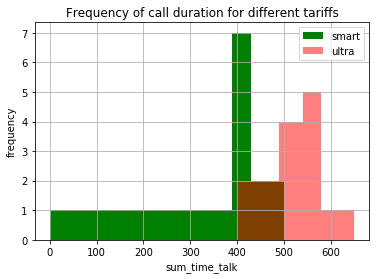

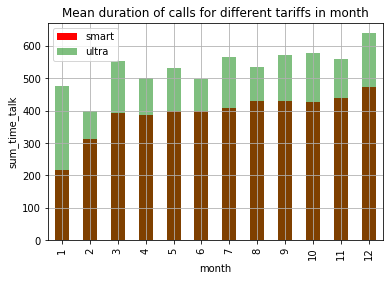

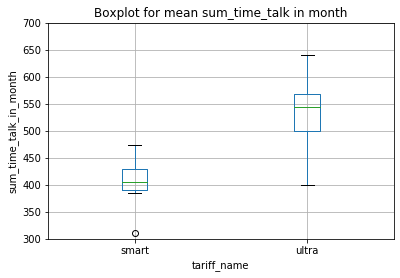

In [114]:
# строим гистограмму частот для минут разговора
num_bins=[0,220,370, 390,430, 500]
smart_call_hist= total_smart.hist(['sum_time_talk'],bins=num_bins,color='green', label='smart')
num_bins=[300,400,490,540, 580,650]
total_ultra.hist(['sum_time_talk'],bins=num_bins, ax=smart_call_hist, color='red', alpha=0.5, label='ultra')
plt.legend(['smart', 'ultra'])
plt.xlabel('sum_time_talk')
plt.ylabel('frequency')
plt.title('Frequency of call duration for different tariffs')
# строим график минут разговора по месяцам

smart_call = total_smart.plot(x='month',y='sum_time_talk',kind='bar', label='smart',color= 'red',stacked=True)
total_ultra.plot(x='month',y='sum_time_talk', ax= smart_call,alpha=0.5,color= 'green', stacked=True,kind='bar', label='ultra', grid=True)
plt.xlabel('month')
plt.ylabel('sum_time_talk')
plt.title('Mean duration of calls for different tariffs in month')
plt.show()

#строим диаграмму размаха
total_talk_mes_trf_stat.boxplot(by=['tariff_name'],column=['sum_time_talk'])
plt.ylim(300, 700)
plt.title('Boxplot for mean sum_time_talk in month')
plt.suptitle('') 
plt.xlabel('tariff_name')
plt.ylabel('sum_time_talk_in_month')
plt.show()

В течении года количество минут разговора увеличивается для обоих тарифов. Максимальное количество минут приходится на 12-ый месяц месяц:smart-474 мин, ultra-639. Датасет тарифа "smart"скошен вправо.Таким образом, у клиентов тарифа 'smart' длительность разговора в месяц больше медианной, но не превышает максимума в 500 минут. Датасен тарифа 'ultra' скошен влево, тоесть многие пользователи разговариют меньше 540(медианное значение) в месяц. Если предложить этим пользователям тариф 'smart', то недостающие минуты они будут докупать.

##### 3.2.2 График для кол-ва сообщений в месяц

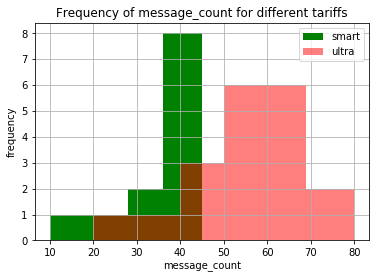

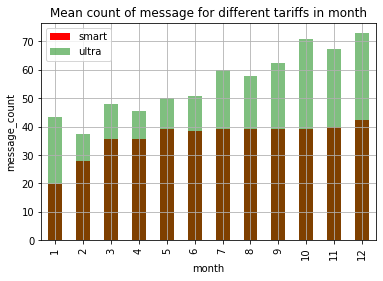

(35, 75)

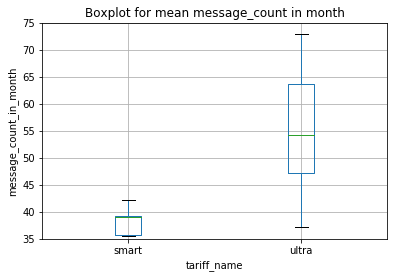

In [123]:
#строим гистограмму частот для кол-ва сообщений
num_bins=[10,23, 28,36,45]
ax=total_smart.hist(['message_count'],bins=num_bins, color='green', label='smart')
num_bins=[10,20,40,50,69,80]
total_ultra.hist(['message_count'],bins=num_bins,ax=ax,alpha=0.5,color= 'red',label='ultra', grid=True)
plt.legend(['smart', 'ultra'])
plt.xlabel('message_count')
plt.ylabel('frequency')
plt.title('Frequency of message_count for different tariffs')
#строим график числа сообщений по месяцам
ax=total_smart.plot(x='month',y='message_count',kind='bar',label='smart',color= 'red')
total_ultra.plot(x='month',y='message_count',kind='bar',ax=ax, alpha=0.5,color= 'green',  label='ultra', grid=True)
plt.xlabel('month')
plt.ylabel('message_count')
plt.title('Mean count of message for different tariffs in month')
plt.show()

#строим диаграмму размаха
total_talk_mes_trf_stat.boxplot(by=['tariff_name'],column=['message_count'])
plt.title('Boxplot for mean message_count in month')
plt.suptitle('') 
plt.xlabel('tariff_name')
plt.ylabel('message_count_in_month')
plt.ylim(35, 75)

В течение года среднее число сообщений в месяц растёт. Только на 12 месяц приходится максимум - 42 сообщения в месяц для тарифа "smart" и 72 для тарифа "ultra". Датасет тарифа smart сильно скошен влево, то есть среднее кол-во сообщений пользователей в месяц меньше медианного. Пользователи тарифа ultra никгда не отправляют 1000 сообщений в месяц. В среднем месяц отправляется от 49 до 62 сообщений.

#### 3.2.3. График для объёма потраченного интернет трафика

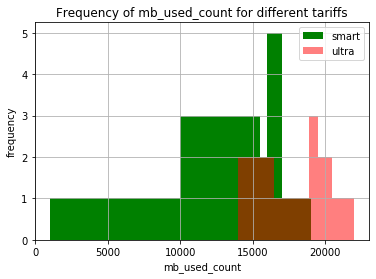

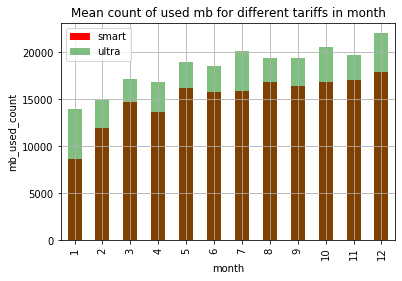

(7500, 23000)

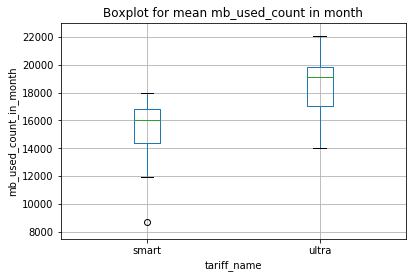

In [124]:
num_bins=[1000,10000,15500,16000, 17000,19000]
ax=total_smart.hist(['mb_used_count'],bins=num_bins,color='green', label='smart')
num_bins=[13000,14000, 16500,17100,18000,18900,19500,20500,22000]
total_ultra.hist(['mb_used_count'],bins=num_bins,ax=ax, alpha=0.5, color= 'red',label='ultra', grid=True)
plt.legend(['smart', 'ultra'])
plt.xlabel('mb_used_count')
plt.ylabel('frequency')
plt.title('Frequency of mb_used_count for different tariffs')
#строим график среднего объёма траффика в месяц
ax=total_smart.plot(x='month',y='mb_used_count',kind='bar',label='smart',color= 'red')
total_ultra.plot(x='month',y='mb_used_count',kind='bar',ax=ax,color= 'green',alpha=0.5, label='ultra', grid=True)
plt.xlabel('month')
plt.ylabel('mb_used_count')
plt.title('Mean count of used mb for different tariffs in month')
plt.show()
#строим диаграмму размаха
total_talk_mes_trf_stat.boxplot(by=['tariff_name'],column=['mb_used_count'])
plt.title('Boxplot for mean mb_used_count in month')
plt.suptitle('') 
plt.xlabel('tariff_name')
plt.ylabel('mb_used_count_in_month')
plt.ylim(7500, 23000)

Объём трафика повышается c колебаниями в течение года.Достигает максимального значения- 18000 мб для тарифа smart и 22000 мб для тарифа ultra. В среднем в месяц пользователи тарифа ultra используют объём траффика меньше медианного, а в 1-ый и 2-ой месяц максимальный объём трафика составил 15 гб. 

### Вывод

В целом,многие пользователи тарифа ultra не используют все возможности тарифа. Если бы они перешли на тариф smart,  то для них было бы выгоднее докупать необходимые услуги.

### 4. Проверка гипотез

#### 4.1   Значима ли разница между средней вырочкой пользователей тарифов «Ультра» и «Смарт»

#### 4.1.1 Cоздадим датасеты выручки пользователей для каждого тарифа

In [117]:
smart_revenue= total_table_revenue.query('tariff_name=="smart"')
ultra_revenue= total_table_revenue.query('tariff_name=="ultra"')

In [118]:
# посчитаем суммарную выручку для каждого тарифа
total_table_revenue.groupby('tariff_name')['total_revenue'].sum()

tariff_name
smart    2988603.80
ultra     601191.25
Name: total_revenue, dtype: float64

#### 4.1.2 Формулируем нулевую гипотезу

Нулевая гипотеза: разница между выручками не значима. Они равны между собой.
Альтернативная:разница между выручками значима. Они не равны между собой.

In [119]:
from scipy import stats as st
import numpy as np
alpha = 0.05
results =st.ttest_ind(
    smart_revenue['total_revenue'],
    ultra_revenue['total_revenue'])
print('p-значение:',results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.244425362266183e-31
Отвергаем нулевую гипотезу


#### Вывод

Средняя вырочка от пользователей тарифов smart и ultra различается. Нулевая гипотеза была сформулирована так, чтобы использовать знак равенства.

#### 4.2 Отличается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов

#### 4.2.1 Создади датесеты для Москвы и других регионов

In [120]:
# добавим в таблицу с выручкой города
users_city = data_users.filter(['user_id', 'city'],axis=1).set_index('user_id')
revenue_city=total_table_revenue.merge(users_city, on=['user_id']).reset_index(drop=True)
revenue_city=revenue_city.fillna(0)
revenue_city

,user_id,month,tariff_name,total_revenue,city
0,1000,5,ultra,-2238.60,Краснодар
1,1000,6,ultra,962.55,Краснодар
2,1000,7,ultra,-240.60,Краснодар
3,1000,8,ultra,-158.50,Краснодар
4,1000,9,ultra,-47.85,Краснодар
...,...,...,...,...,...
2657,1498,10,smart,1915.80,Владикавказ
2658,1499,9,smart,-2459.40,Пермь
2659,1499,10,smart,1980.80,Пермь
2660,1499,11,smart,2537.80,Пермь


In [121]:
# разобьём данные для Москвы и других регионов
revenue_city_Moscow=revenue_city.query('city=="Москва"')
revenue_city_region=revenue_city.query('city!="Москва"')

#### 4.2.2. Формулируем нулевую гипотезу

Нулевая гипотеза:статистически выручки не различаются. Альтернативная гипотеза:да, выручки статистически различаются.

In [122]:
alpha = 0.05
results =st.ttest_ind(
    revenue_city_Moscow['total_revenue'],
    revenue_city_region['total_revenue'])
print('p-значение:',results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
    

p-значение: 0.7820565993543117
Не получилось отвергнуть нулевую гипотезу


#### Вывод

Выручки от пользователей из Москвы  и других регионов не различаются.

### Общий вывод

Были проанализированны данные из пяти таблиц. При обработке данных были найдены нулевые значения, которые было решено удалить. Некоторые типы данных были изменены на более подходищие. В целом данные были хорошего качества.
Результаты анализа данных показали, что пользователи начали подлючаться к тарифам smart  и ultra начиная с 3-его месяца. И с каждым месяцем объём использования тарифов и выручка увеличивались.

<div>По результатам анализа было выдвинуто две гипотезы:</div>
<div>1)Сравнивая доходность тарифов была выдвинута гипотеза, что между выручками двух тарифов нет статистической разницы. Применив к двум зависимым критерий стьюдента, выяснили,что статистическая разница есть. Гипотеза была отвергнута. При подсчёте общей выручки для каждого из тарифов было выявлено, что тариф smart приносит больший доход-2988603.80 рублей, в сравнении с тарифов ultra-601191.25 рублей.</div>
2)Также была выдвинута гипотеза, что выручки для Москвы и регионов статически не различаются. Гипотеза не была отвергнута, соответственно статистически выручки равнозначны.

Рекомендации:
<div>1)Так как доход с тарифа smart в 5 раз больше, выгоднее будет вкладывать деньги в его рекламу и развитие. </div>
2)Учитывая, что выручка для Москвы и регионов статистически равнозначна, будет дешевле продвигать тарифы в регионах. 